# Practica 3

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# read the first file
NaCoCo = np.loadtxt('calibracionNaCoCoCs-Ge8K.xy')

# read the second file
Eu = np.loadtxt('calibracionEu-Ge8K.xy')

## Preparación

1. Gráfica del espectro de calibración

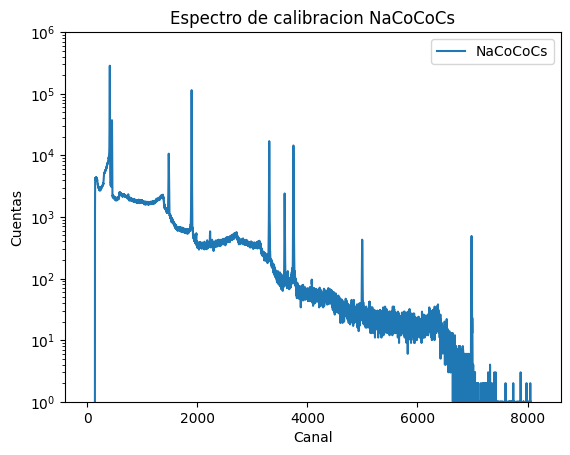

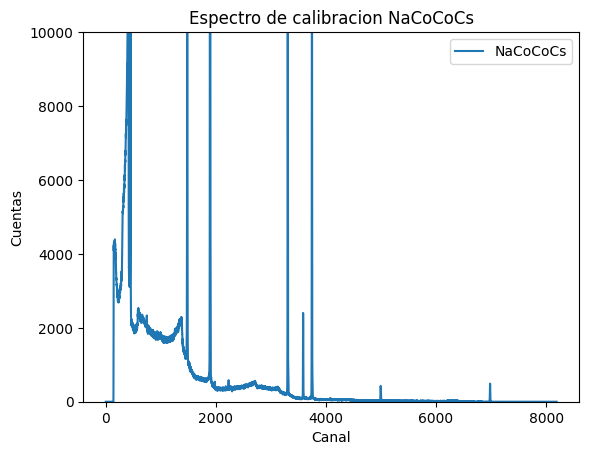

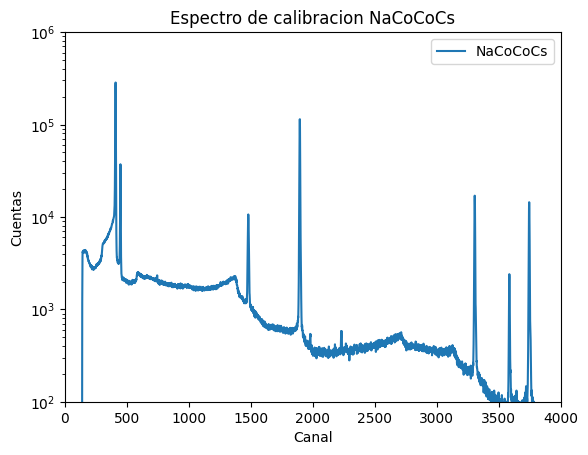

In [30]:
# Grafica de los datos NaCoCo. Eje y en escala logaritmica


plt.plot(NaCoCo[:,0], NaCoCo[:,1], label='NaCoCoCs')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title('Espectro de calibracion NaCoCoCs')
plt.yscale('log')
plt.ylim(1, 1e6)
plt.legend()
plt.show()

plt.plot(NaCoCo[:,0], NaCoCo[:,1], label='NaCoCoCs')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title('Espectro de calibracion NaCoCoCs')
plt.ylim(0,10e3)
plt.legend()
plt.show()

plt.plot(NaCoCo[:,0], NaCoCo[:,1], label='NaCoCoCs')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title('Espectro de calibracion NaCoCoCs')
plt.yscale('log')
plt.ylim(1e2, 1e6)
plt.xlim(0, 4000)
plt.legend()
plt.show()

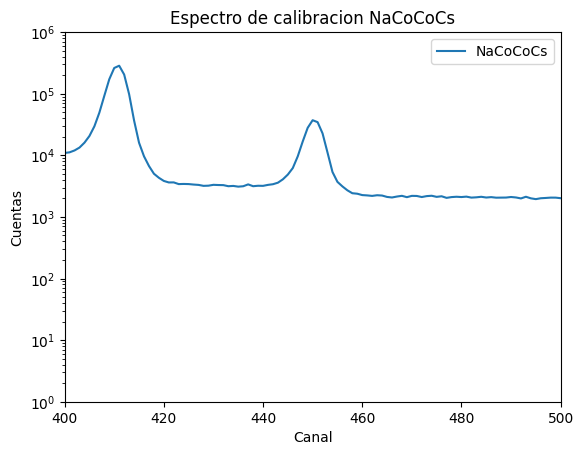

In [82]:

plt.plot(NaCoCo[:,0], NaCoCo[:,1], label='NaCoCoCs')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title('Espectro de calibracion NaCoCoCs')
plt.ylim(1, 1e6)
plt.yscale('log')
plt.xlim(400,500)
plt.legend()
plt.show()

Considerando los elementos los picos esperados 

In [69]:
# create a dictionary with the values and their corresponding names
values = {'22Na_1': 1274.537,
          '60Co_1': 1173.228,
          '60Co_2': 1332.490,
          '137Cs_1': 661.657,
          '137Cs_alfa': 32.06,
          '137Cs_beta': 36.66,
          '57Co_1': 122.06065,
          '57Co_2': 136.47350,
          'electron': 511,
          '60Co_3': 2505.748}

# sort the dictionary by its keys
p_energia = sorted(values.items(), key=lambda x: x[1])

# create a new list with values except '137Cs_alfa' and '137Cs_beta'
p_energia_adj = [(key, value) for key, value in p_energia if key not in ['137Cs_alfa', '137Cs_beta']]

2. Asignación de los picos de energía

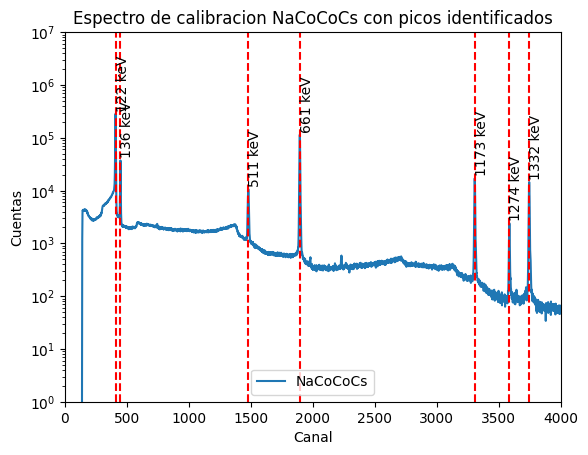

In [73]:
# Se estima que los picos están en los canales:

p_canal_estimado = [410, 450, 1490, 1900, 3300, 3590, 3750, 5000]

# Se busca el valor p_canal maximo real a partir del valor p_canal_estimado

p_canal = []

for i in range(len(p_energia_adj)):
    p_canal.append(np.argmax(NaCoCo[p_canal_estimado[i]-30:p_canal_estimado[i]+30,1])+p_canal_estimado[i]-30)

# plot the spectrum of NaCoCo
plt.plot(NaCoCo[:,0], NaCoCo[:,1], label='NaCoCoCs')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title('Espectro de calibracion NaCoCoCs con picos identificados')
plt.yscale('log')
plt.ylim(1, 1e7)
plt.legend()

# add vertical lines and text for energy peaks (-1 es para no imprimir el ultimo pico)
for i in range(len(p_canal)-1):
    plt.axvline(x=p_canal[i], color='r', linestyle='--')
    plt.text(p_canal[i], 1.1*NaCoCo[p_canal[i],1], str(int(p_energia_adj[i][1]))+' keV', va='bottom',rotation=90)
plt.xlim(0, 4000)
plt.show()

In [151]:
e_canal = [(p_energia_adj[i][0],p_energia_adj[i][1], p_canal[i]) for i in range(len(p_canal))]

# eliminar los valores de e_canal para 57Co_2 y electron

e_canal_cal = [(key, value, canal) for key, value, canal in e_canal if key not in ['57Co_2', 'electron', '60Co_1']]


# Ajuste de gaussiana al rededor de cada fotopico de e_canal_cal

from scipy.optimize import curve_fit

def gaussiana_lineal(x, a, x0, sigma, b_0, b_1):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b_0 + b_1*x

def gaussiana(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))
# Se define un rango de ajuste para cada fotopico

rango_ajuste = [(canal-30, canal+30) for key, value, canal in e_canal_cal]

# Se define un rango de ajuste para cada fotopico
# los parametros optimos son guardados en popt y la covarianza en pcov
# popt_i = [a, x0, sigma] para el i-esimo fotopico
# pcov_i = matriz de covarianza para el i-esimo fotopico
# a = amplitud, x0 = centro, sigma = desviacion estandar

popt = []
pcov = []

for i in range(len(rango_ajuste)):
    popt_i, pcov_i = curve_fit(gaussiana_lineal, NaCoCo[rango_ajuste[i][0]:rango_ajuste[i][1],0], NaCoCo[rango_ajuste[i][0]:rango_ajuste[i][1],1], p0=[NaCoCo[e_canal_cal[i][2],1], e_canal_cal[i][2], 10, 0, 0], bounds=([-np.inf, -np.inf, 0, -np.inf, -np.inf], [np.inf, np.inf, np.inf, np.inf, np.inf]))
    popt.append(popt_i)
    pcov.append(pcov_i)
incertidumbres = np.sqrt(np.diagonal(pcov, axis1=1, axis2=2))


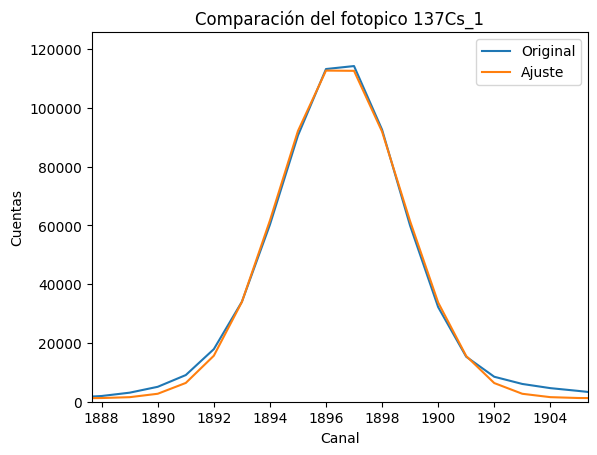

In [152]:
# calculate the adjusted values of the counts for each channel
ajuste = [gaussiana_lineal(NaCoCo[:,0], *popt_i) for popt_i in popt]
ajuste_sin_fondo = [gaussiana(NaCoCo[:,0], *popt_i[0:3]) for popt_i in popt]
# plot the first gaussian linear along with the original values to compare and limit the width to 4 sigma
graph_i = 1
plt.plot(NaCoCo[:,0], NaCoCo[:,1], label='Original')
plt.plot(NaCoCo[:,0], ajuste[graph_i], label='Ajuste')
plt.xlabel('Canal')
plt.ylabel('Cuentas')
plt.title(f'Comparación del fotopico {e_canal_cal[graph_i][0]}')
plt.xlim(popt[graph_i][1]-4*popt[graph_i][2], popt[graph_i][1]+4*popt[graph_i][2])
plt.ylim(0, 1.1*popt[graph_i][0])
plt.legend()
plt.show()


In [163]:
from scipy.integrate import quad

intensidades = []
incertidumbres_int = []

def integ_riemman(x,y):
    integral = 0
    dx = x[1]-x[0]
    for i in range(len(x)):
        integral = integral + dx*y[i]
    return integral

sigmas = 1
rango_integracion = [(int(popt[i][1]-sigmas*popt[i][2]), int(popt[i][1]+sigmas*popt[i][2])) for i in range(len(popt))]
print("Ajustes con fondo")
for i in range(len(popt)):
    integral = integ_riemman(NaCoCo[rango_integracion[i][0]:rango_integracion[i][1],0], ajuste[i][rango_integracion[i][0]:rango_integracion[i][1]])
    intensidades.append(integral)
    incertidumbres_int.append(incertidumbres[i][0]*integral/popt[i][0])

for i in range(len(intensidades)):
    print(f'Intensidad del pico {e_canal_cal[i][0]}: {intensidades[i]:.2f} +/- {incertidumbres_int[i]:.2f}')

print("Ajustes sin fondo")

intensidades_sin_fondo = []
incertidumbres_int_sin_fondo = []

for i in range(len(popt)):
    integral = integ_riemman(NaCoCo[rango_integracion[i][0]:rango_integracion[i][1],0], ajuste_sin_fondo[i][rango_integracion[i][0]:rango_integracion[i][1]])
    intensidades_sin_fondo.append(integral)
    incertidumbres_int_sin_fondo.append(incertidumbres[i][0]*integral/popt[i][0])

for i in range(len(intensidades_sin_fondo)):
    print(f'Intensidad del pico {e_canal_cal[i][0]}: {intensidades_sin_fondo[i]:.2f} +/- {incertidumbres_int_sin_fondo[i]:.2f}')



Ajustes con fondo
Intensidad del pico 57Co_1: 812257.99 +/- 9427.85
Intensidad del pico 137Cs_1: 379017.17 +/- 2464.15
Intensidad del pico 22Na_1: 10446.94 +/- 92.01
Intensidad del pico 60Co_2: 69054.98 +/- 402.83
Intensidad del pico 60Co_3: 2902.27 +/- 31.70
Ajustes sin fondo
Intensidad del pico 57Co_1: 781989.72 +/- 9076.53
Intensidad del pico 137Cs_1: 374265.81 +/- 2433.26
Intensidad del pico 22Na_1: 9896.73 +/- 87.16
Intensidad del pico 60Co_2: 67881.84 +/- 395.98
Intensidad del pico 60Co_3: 2671.98 +/- 29.18


[ 1.14326058e+05  1.89649608e+03  2.21107293e+00 -1.38049309e+02
  6.99492966e-01]
